In [29]:
import json
import os
import numpy as np
import pandas as pd
import emoji

#root = "sejal"

dirs = ["sejal", "camille"]
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

identifier, photos, captions = [], [], []
collections, no_image, no_caption = 0, 0, 0
scraper_failed = 0
posts_per_user = []
mentions, hashtags, emojis, has_quotes, vanilla = 0, 0, 0, 0, 0
running_total = 0
finsta, finsta_users = 0, 0
for root in dirs:
    for fn in os.listdir("profiles_" + root + "/"):
        if fn.endswith(".json"):
            f = open("profiles_" + root + "/" + fn)
            num_valid_entries = 0
            num_invalid_entries = 0
            user_identifiers, user_photos, user_captions = [], [], []
            h, m, q, e, v = 0, 0, 0, 0, 0
            data = json.load(f)
            if data["followers"]["count"] >= 200:
                try:
                    posts = data["posts"]
                except:
                    if data["num_of_posts"] >= 0 and data["num_of_posts"] <= 100:
                        print(data["num_of_posts"])
                        scraper_failed += data["num_of_posts"]
                    else:
                        scraper_failed += 100
                for p in posts:
                    if len(p["imgs"]) > 1:
                        collections += 1
                        num_invalid_entries += 1
                    elif len(p["imgs"]) == 0:
                        no_image += 1
                        num_valid_entries += 1
                    elif p["caption"] == "":
                        no_caption += 1
                        num_invalid_entries += 1
                    else:
                        num_valid_entries += 1
                        vanilla_flag = True
                        user_identifiers.append(data["username"])
                        user_photos.append(p["imgs"][0])
                        if '"' in p["caption"]:
                            q += 1
                            vanilla_flag = False
                        if '@' in p["caption"]:
                            m += 1
                            vanilla_flag = False
                        if '#' in p["caption"]:
                            h += 1
                            vanilla_flag = False
                        if text_has_emoji(p["caption"]):
                            e += 1
                            vanilla_flag = False
                        if vanilla_flag:
                            v += 1
                        user_captions.append(p["caption"].replace('"', '\''))
                if num_valid_entries >= 10:
                    running_total += num_valid_entries
                    hashtags += h
                    has_quotes += q
                    mentions += m
                    emojis += e
                    vanilla += v
                    identifier.append(user_identifiers)
                    photos.append(user_photos)
                    captions.append(user_captions)
                else:
                    pass
                posts_per_user.append(num_valid_entries)
                if data["num_of_posts"] < 100:
                    scraper_failed += data["num_of_posts"] - num_valid_entries - num_invalid_entries
                else:
                    scraper_failed += 100 - num_valid_entries - num_invalid_entries
            else:
                finsta += len(data["posts"])
                finsta_users += 1
            f.close()
        
print(finsta_users)
left_space = 25
num_space = 8
too_few = sum([p if (p < 10 and p > 0) else 0 for p in posts_per_user])
total = running_total + collections + no_image + no_caption + too_few + finsta
print("classification".ljust(left_space), "# posts".rjust(num_space), "pct %".rjust(num_space))
print("–––––––––––––––––––––––".ljust(left_space), "––––––".rjust(num_space), "––––––".rjust(num_space))
print("scraper failed".ljust(left_space), str(scraper_failed).rjust(num_space), str(round(scraper_failed * 100/ (total + scraper_failed), 2)).rjust(num_space))
print("TOTAL SCRAPED".ljust(left_space), ("("+str(total)+")").rjust(num_space))
print("")
print("total number of users".ljust(left_space), str(len(posts_per_user)).rjust(num_space))
posts_per_user2 = [p for p in posts_per_user if p >= 10]
print("mean ppu [before]".ljust(left_space), str(round(np.mean(posts_per_user), 2)).rjust(num_space))
print("median ppu [before]".ljust(left_space), str(np.median(posts_per_user)).rjust(num_space))
print("dumping out (users)".ljust(left_space), str(len(posts_per_user) - len(posts_per_user2)).rjust(num_space))
print("dumping out (posts)".ljust(left_space), str(too_few).rjust(num_space))
print("mean ppu [after]".ljust(left_space), str(round(np.mean(posts_per_user2), 2)).rjust(num_space))
print("median ppu [after]".ljust(left_space), str(np.median(posts_per_user2)).rjust(num_space))
print("")

throwing_out = collections + no_image + no_caption + too_few + finsta
print("THROWING OUT".ljust(left_space), ("(" + str(throwing_out) + ")").rjust(num_space), ("("+str(round(throwing_out * 100 / total, 2))+")").rjust(num_space))
print("no caption".ljust(left_space), str(no_caption).rjust(num_space), str(round((no_caption / total) * 100, 2)).rjust(num_space))
print("no image".ljust(left_space), str(no_image).rjust(num_space), str(round((no_image / total) * 100, 2)).rjust(num_space))
print("collection".ljust(left_space), str(collections).rjust(num_space), str(round((collections / total) * 100, 2)).rjust(num_space))
print("too few".ljust(left_space), str(too_few).rjust(num_space), str(round((too_few / total) * 100, 2)).rjust(num_space))
print("finsta / loner".ljust(left_space), str(finsta).rjust(num_space), str(round((finsta / total) * 100, 2)).rjust(num_space))

print("")

print("USABLE".ljust(left_space), ("(" + str(running_total) + ")").rjust(num_space), ("("+str(round(running_total*100/total, 2))+")").rjust(num_space))
print("<< vanilla >>".ljust(left_space), str(vanilla).rjust(num_space), str(round((vanilla / total) * 100, 2)).rjust(num_space))
nonvanilla = running_total - vanilla
print("<< non-vanilla >>".ljust(left_space), str(nonvanilla).rjust(num_space), str(round((nonvanilla / total) * 100, 2)).rjust(num_space))
print("   mentions".ljust(left_space), str(mentions).rjust(num_space), str(round((mentions / total) * 100, 2)).rjust(num_space))
print("   hashtags".ljust(left_space), str(hashtags).rjust(num_space), str(round((hashtags / total) * 100, 2)).rjust(num_space))
print("   emojis".ljust(left_space), str(emojis).rjust(num_space), str(round((emojis / total) * 100, 2)).rjust(num_space))
print("   has quotes".ljust(left_space), str(has_quotes).rjust(num_space), str(round((has_quotes / total) * 100, 2)).rjust(num_space))

#print("–––––––––––––––––––––––––".center(left_space), "–––––".rjust(num_space), "–––––".rjust(num_space))

#with open('data_' + root + '.csv', 'w') as f:
with open('masterdata.csv', 'w') as f:
    f.write("username,photo,caption\n")
    for i in range(len(photos)):
        for j in range(len(photos[i])):
            f.write("%s,%s,\"%s\"\n" % (identifier[i][j],photos[i][j], captions[i][j]))
f.close()

try:
    #csv = pd.read_csv('data_' + root + '.csv', header=0)
    csv = pd.read_csv('masterdata.csv', header=0)
    csv.drop_duplicates(keep="last",inplace=True)
    #csv.to_csv('data_' + root + '.csv', index=False)
    csv.to_csv('masterdata.csv', index=False)
except:
    print('pandas stuff did not work')


209
classification             # posts    pct %
–––––––––––––––––––––––     ––––––   ––––––
scraper failed               32296    25.14
TOTAL SCRAPED              (96149)

total number of users         1903
mean ppu [before]            33.25
median ppu [before]           22.0
dumping out (users)            624
dumping out (posts)           2234
mean ppu [after]             47.73
median ppu [after]            48.0

THROWING OUT               (35108)  (36.51)
no caption                    5997     6.24
no image                      2400      2.5
collection                   20393    21.21
too few                       2234     2.32
finsta / loner                4084     4.25

USABLE                     (61041)  (63.49)
<< vanilla >>                25260    26.27
<< non-vanilla >>            35781    37.21
   mentions                   4762     4.95
   hashtags                  11806    12.28
   emojis                    23072     24.0
   has quotes                 1063     1.11


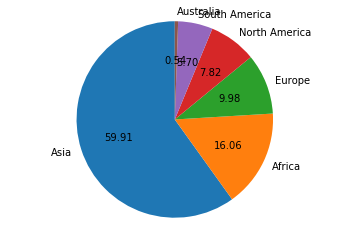

In [51]:
import matplotlib.pyplot as plt
pieLabels = ['Asia', 'Africa', 'Europe', 'North America', 'South America', 'Australia']
populationShare = [59.69, 16, 9.94, 7.79, 5.68, 0.54]
figureObject, axesObject = plt.subplots()
axesObject.pie(populationShare, labels=pieLabels, autopct='%1.2f', startangle=90)
axesObject.axis('equal')
plt.show()

[[ 5565  2148 18897  2197  3987]
 [23226 32308     0     0     0]]


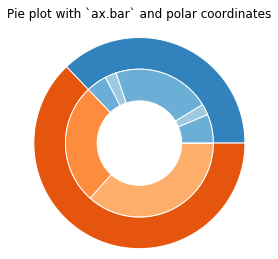

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw=dict(polar=True))

size = 0.3
vals = np.array([[no_caption, no_image, collections, too_few, finsta], [vanilla, nonvanilla, 0, 0, 0]])
labels = np.array([["no caption", "no image", "collection", "too few", "finsta"], ["vanilla", "non-vanilla", 0, 0, 0]])
print(vals)
#normalize vals to 2 pi
valsnorm = vals/np.sum(vals)*2*np.pi
#obtain the ordinates of the bar edges
valsleft = np.cumsum(np.append(0, valsnorm.flatten()[:-1])).reshape(vals.shape)

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap(np.array([1, 2, 1, 2, 1, 5, 6, 0, 0]))

ax.bar(x=valsleft[:, 0],
       width=valsnorm.sum(axis=1), bottom=1-size, height=size,
       color=outer_colors, edgecolor='w', linewidth=1, label=labels, align="edge")

ax.bar(x=valsleft.flatten(),
       width=valsnorm.flatten(), bottom=1-2*size, height=size,
       color=inner_colors, edgecolor='w', linewidth=1, align="edge")

ax.set(title="Pie plot with `ax.bar` and polar coordinates")
ax.set_axis_off()
plt.show()

In [ ]:
import csv
csv_file = 'camillebowman_followers.csv'
txt_file = 'camille_followers.txt'
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        i = 0
        for row in csv.reader(my_input_file):
            if i == 0:
                my_output_file.write(''.join(row)[1::] + '\n')
            elif i % 2 == 0:
                my_output_file.write(''.join(row) + '\n')
            i += 1
    my_output_file.close()